In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_sequence
import nltk
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [15]:
import sys; sys.path.append("..")
import proj_dataset

proj_dataset.FOLDERSPATH = r'..\\datasets'
train_loader, val_loader, test1_loader, test2_loader, vocab = proj_dataset.get_loaders(train_size=40_000)

Loaded 13240 lines from ..\\datasets\\OLID\\OLID_Tain.txt
Loaded 5852 lines from english_dataset.tsv
Loaded 1153 lines from hasoc2019_en_test-2919.tsv
Loaded 40000 lines from 1


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hanne\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
c:\Users\hanne\Desktop\d7047e\Project\BiLSTM\..\proj_dataset.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label1'] = data['label1'].astype(int)
c:\Users\hanne\Desktop\d7047e\Project\BiLSTM\..\proj_dataset.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tokens'] = data['sentence'].apply(word_tokenize)
c:\Users\hanne\Desktop\d7047e\Pro

42269 17664 18435 24687 67599


In [16]:
class SelfAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(SelfAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.projection = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(True),
            nn.Linear(32, 1)
        )

    def forward(self, encoder_outputs):
       
        energy = self.projection(encoder_outputs)  # [batch_size, seq_len, 1]
        weights = torch.softmax(energy.squeeze(-1), dim=1)  # [batch_size, seq_len]
        outputs = (encoder_outputs * weights.unsqueeze(-1)).sum(dim=1)  # [batch_size, hidden_dim * 2]
        return outputs

class BiLSTMWithSelfAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=1):
        super(BiLSTMWithSelfAttention, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=True, batch_first=True)
        self.attention = SelfAttention(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)
        # Apply self-attention
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        attended_output = self.attention(output)
        output = self.fc(attended_output)
        return output


In [20]:
# Hyperparameters
vocab_size = len(vocab) + 1  # plus one for padding index
embedding_dim = 50
hidden_dim = 128
output_dim = 2  # binary classification

model = BiLSTMWithSelfAttention(vocab_size, embedding_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=3e-3, weight_decay=0.5)
loss_fn = nn.CrossEntropyLoss()

# GPU if available
device = torch.device('cpu') #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BiLSTMWithSelfAttention(
  (embedding): Embedding(67600, 50)
  (lstm): LSTM(50, 128, batch_first=True, bidirectional=True)
  (attention): SelfAttention(
    (projection): Sequential(
      (0): Linear(in_features=256, out_features=32, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (fc): Linear(in_features=256, out_features=2, bias=True)
)

In [22]:
def train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=2):
    model.train()
    for epoch in range(epochs):
        train_loss = 0.0
        avg_train_loss = 0.0
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            predictions = model(texts)
            loss = loss_fn(predictions, labels)
            train_loss += loss.item() * texts.size(0)  # Accumulate the loss
            loss.backward()
            optimizer.step()
        
        avg_train_loss = train_loss / len(train_loader.dataset)

        val_loss = 0.0
        avg_val_loss = 0.0
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            for texts, labels in val_loader:
                texts, labels = texts.to(device), labels.to(device)
                predictions = model(texts)
                loss = loss_fn(predictions, labels)
                val_loss += loss.item() * texts.size(0)  # Accumulate the loss

        avg_val_loss = val_loss/len(val_loader.dataset)

        print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')



train_model(model, train_loader, val_loader,optimizer, loss_fn)

Classification Report:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50      4400
           1       0.00      0.00      0.00      8840

    accuracy                           0.33     13240
   macro avg       0.17      0.50      0.25     13240
weighted avg       0.11      0.33      0.17     13240

Confusion Matrix
[[4400    0]
 [8840    0]]
ROC AUC Score:
0.4740353635335253


C:\Users\hanne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hanne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hanne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471

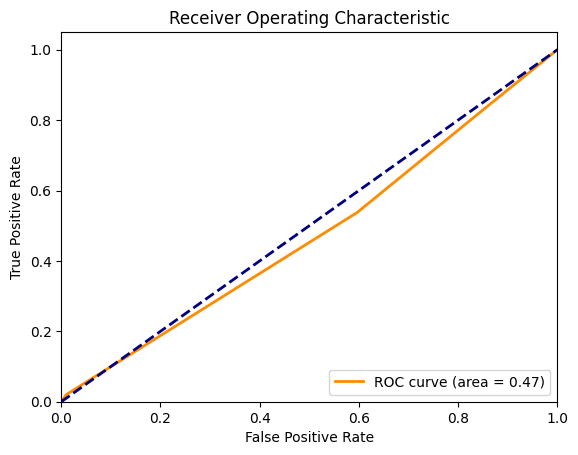

Classification Report:
              precision    recall  f1-score   support

           0       0.30      1.00      0.46      2106
           1       0.00      0.00      0.00      4899

    accuracy                           0.30      7005
   macro avg       0.15      0.50      0.23      7005
weighted avg       0.09      0.30      0.14      7005

Confusion Matrix
[[2106    0]
 [4899    0]]
ROC AUC Score:
0.49850571283516787


C:\Users\hanne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hanne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hanne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471

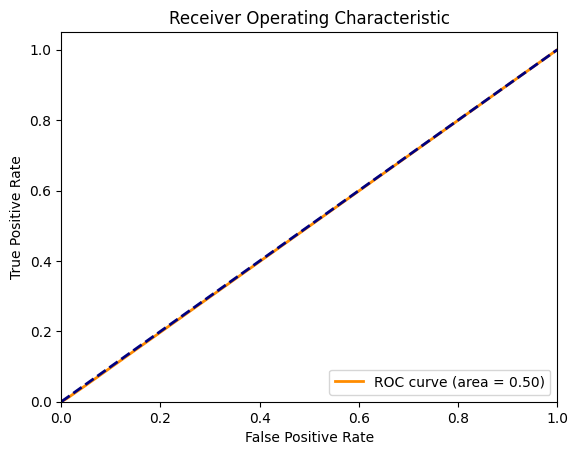

'\nClass-wise results:\nEach row under the class labels (like 0 and 1 in your case,\ntypically representing different classes such as "OFF" and "NOT")\nshows the precision, recall, F1 score, and support for that class.\n\nAccuracy:\nThis is the ratio of correctly predicted observations\nto the total observations and is provided separately.\n\nMacro average:\nThis is calculated by taking the average of\nthe precision, recall, and F1 score for each class, without taking support\ninto account. It treats all classes equally, regardless of how many instances\nthere are in each class.\n\nWeighted average:\nThis takes the average of the precision, recall, and F1 score\nfor each class, weighted by the support (the number of true instances for\neach class). This method accounts for class imbalance;\nit calculates metrics in which each classs metric is weighted\nby its presence in the true data.\n'

In [19]:
from sklearn.metrics import classification_report, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []  # List to store probabilities for the positive class

    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            # Using softmax to calculate probabilities
            softmax = torch.nn.Softmax(dim=1)
            probs = softmax(outputs).cpu().numpy()[:, 1]
            all_probs.extend(probs)

    # Calculate metrics
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))
    print("Confusion Matrix")
    print(confusion_matrix(all_labels, all_preds))

    # ROC AUC and ROC Curve are applicable only for binary classification
    if output_dim == 2:
        roc_auc = roc_auc_score(all_labels, all_probs)
        fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

        print("ROC AUC Score:")
        print(roc_auc)

        # Plot ROC curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

evaluate_model(model, test1_loader)
evaluate_model(model, test2_loader)

'''
Class-wise results:
Each row under the class labels (like 0 and 1 in your case,
typically representing different classes such as "OFF" and "NOT")
shows the precision, recall, F1 score, and support for that class.

Accuracy:
This is the ratio of correctly predicted observations
to the total observations and is provided separately.

Macro average:
This is calculated by taking the average of
the precision, recall, and F1 score for each class, without taking support
into account. It treats all classes equally, regardless of how many instances
there are in each class.

Weighted average:
This takes the average of the precision, recall, and F1 score
for each class, weighted by the support (the number of true instances for
each class). This method accounts for class imbalance;
it calculates metrics in which each classs metric is weighted
by its presence in the true data.
'''